## CILP & Cross-Modal Fine-Tuning Assessment

This notebook builds on previous insights (`01_*`, `02_*`, `03_*`) and the `Embedder` class to perform cross-modal RGB→LiDAR projection and fine-tuning. The workflow includes:

1. **LiDAR Classifier Training:** Train `LidarClassifier` on LiDAR images and save the best checkpoint.  
2. **Contrastive Image-LiDAR Pretraining (CILP):** Train two `Embedder`s on RGB and LiDAR images with a CLIP-like contrastive loss (`EfficientCILPModel`) and save the best checkpoint.  
3. **Cross-Modal Projection:** Train a `CrossModalProjector` to optimally map RGB embeddings to the LiDAR embedding space.  
4. **RGB→LiDAR Fine-Tuning:** Fine-tune the combined `CILP.Embedder + CrossModalProjector + LidarClassifier.classifier` pipeline with a specific optimizer, learning rate, and layer-unfreeze strategy.  

All models use the same `Embedder` backbone from notebooks `02_*` and `03_*`, which outputs a $200$-dimensional feature map after $4$ convolutional layers and employs MaxPool downsampling (kernel=$2$). The objective is to achieve $\geq 95\%$ accuracy** on RGB inputs compared to the baseline $50\%$ accuracy of a LiDAR-only classifier.  

The first section defines the experiment configuration, including path setup and initialization of the relevant data loaders.

In [1]:
%load_ext autoreload
%autoreload 2

import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import json 
import torch
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

import pandas as pd

from handsoncv.datasets import CILPFusionDataset
from handsoncv.models import (
    LidarClassifier, EfficientCILPModel, CrossModalProjector, RGB2LiDARClassifier
)
from handsoncv.training import train_fusion_cilp_model, search_checkpoint_model
from handsoncv.utils import set_seed, seed_worker
from handsoncv.visualization import plot_table_task4_metrics
from torchvision import transforms
from torch.utils.data import DataLoader

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
IMG_SIZE = 64
BATCH_SIZE = 32

Using GPU: NVIDIA GeForce RTX 3090
cuda


In the following cell, we set a fixed random seed to ensure reproducible data shuffling in the DataLoader multiprocessing pipeline. We then use a custom data-loading function implemented in `src/datasets.py`, which constructs the training and validation splits from predefined sample lists. These lists were generated and saved earlier in `01_dataset_exploration.ipynb`. For details on the creation procedure, refer to `01_dataset_exploration.ipynb`, and for information on the subset size used in the experiments, see the configuration logs in the public [handsoncv-cilp-assessment project link](https://wandb.ai/handsoncv-research/handsoncv-cilp-assessment?nw=nwuserguarinovanessaemanuela).

In [2]:
# Load split dictionary previouslu created with 01_dataset_exploration.ipynb
mapping_file = "subset_splits.json"
with open(f"{ROOT_PATH}/{mapping_file}", "r") as f:
    splits = json.load(f)
    
SEED = splits["seed"] # From .json file created through notebook 01_dataset_exploration.ipynb 
set_seed(SEED)

# Instantiate Dataset and relative Transformation
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

train_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["train"], transform=img_transforms)
val_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["val"], transform=img_transforms)

# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

print(f"Ready to train with {len(train_ds)} training pairs and {len(val_ds)} validation pairs.")

Seeds set to 42 for reproducibility.
Ready to train with 4799 training pairs and 1200 validation pairs.


Finally, the last configuration cell ensures a balanced distribution of classes within the training and validation batches. This is particularly important because **the datasets provided in the NVIDIA notebooks produced batches containing only a single class**, leading to unreliable accuracy estimates. These three configuration cells are shared across the experimental notebooks `02_*`, `03_*`, and `04_*`.

In [3]:
assert set(train_ds.sample_ids).isdisjoint(set(val_ds.sample_ids)), "DATA LEAKAGE DETECTED!"

leaked_ids = set(train_ds.sample_ids).intersection(set(val_ds.sample_ids))
print(f"Found {len(leaked_ids)} overlapping IDs.")
print(f"Example leaked IDs: {list(leaked_ids)[:10]}")

train_labels = next(iter(train_loader))[-1].cpu().numpy()
val_labels = next(iter(val_loader))[-1].cpu().numpy()
class_prior_train, class_prior_val = train_labels.mean(), val_labels.mean()

print(f"Class prior average in first training batch: {class_prior_train:.4f}, and validation batch: {class_prior_val:.4f}")

if class_prior_train < 0.01 or class_prior_train > 0.99:
    raise ValueError("The training batch is extremely imbalanced "
        f"(class prior = {class_prior_train:.4f}). "
        "It will cause the model to memorize label ordering. "
        "Please recreate the dataset splits."
    )

Found 0 overlapping IDs.
Example leaked IDs: []


Class prior average in first training batch: 0.2812, and validation batch: 0.5625


The following cell defines two parameters shared across all four experiments. These are set at a high level to avoid repetition throughout training and models initialization.

In [4]:
SUBSET_SIZE = len(train_ds) + len(val_ds) 
INTERM_FUSION_EMB_DIM = 200

### Train a LiDAR-Only Classifier (Step 5.1a)

In the following cell, we train a LiDAR-only classifier using the `dynamic_train_fusion_cilp_model` function (implemented in `src/training.py`). All relevant training artifacts - including the first validation predictions, training and validation losses, accuracy, learning rate schedule, GPU memory usage, checkpoints and full configuration logs - are recorded and can be inspected at the associated Weights & Biases project link.

From an architectural perspective, the `LidarClassifier` consists of two main components:
1. A modality-specific `Embedder`, which processes raw 4-channel LiDAR inputs and produces intermediate spatial feature maps of size $[B, 200, 4, 4]$.
2. A lightweight fully connected classification head that maps these features to the final class logits.

This classifier serves a dual role in the overall pipeline. First, it provides a well-converged LiDAR-only baseline for the cube-versus-sphere classification task, despite the inherent risk of overfitting due to the simplistic nature of the dataset. Second, its classification head (`lidar_model.classifier`) will be reused in Step 5.3 as the final prediction layer of the `RGB2LiDARClassifier`, where it will be fine-tuned on projected RGB features to improve cross-modal performance.

> **Important Note.** To improve model generalizability - especially when evaluated on data of a different nature - data augmentation techniques such as random scaling (to encourage learning from partial geometry) and color jitter (to reduce reliance on limited appearance variability) could be applied. Additionally, regularization strategies such as dropout, batch normalization, or explicit loss regularizers may further mitigate overfitting. However, given the simplicity of the task (as also reflected in the NVIDIA lab setup), the absence of these measures still allows meaningful results and analysis. We therefore leave such extensions to future work beyond the scope of this assignment.

In [ ]:
# Configuration to fufill logging requirement
EPOCHS = 10
LEARNING_RATE = 1e-3

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1a_Lidar_Only",
    config={
        "architecture": "LidarClassifier",
        "fusion_strategy": "single_modality",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "subset_size": SUBSET_SIZE #train_N + valid_N #SUBSET_SIZE
    }
)

# Instantiate Classifier on LiDAR images only
lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to("cuda")
# lidar_model = Classifier(1).to("cuda")

optimizer = torch.optim.Adam(lidar_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_lidar = train_fusion_cilp_model(
    lidar_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.BCEWithLogitsLoss(), #torch.nn.CrossEntropyLoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="lidar-only"
)

wandb.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 0: Val Loss: 0.3933, Acc: 86.06% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 1: Val Loss: 0.0563, Acc: 97.80% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 2: Val Loss: 0.0239, Acc: 99.32% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 3: Val Loss: 0.0015, Acc: 100.00% | Mem: 125.5MB
Epoch 4: Val Loss: 0.0044, Acc: 99.83% | Mem: 125.5MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 5: Val Loss: 0.0006, Acc: 100.00% | Me

accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time_sec,█▃▂▁▂▂▂▂▂▃
learning_rate,██▇▇▆▄▃▂▂▁
peak_gpu_mem_mb,▁▆▆▆▆█████
train_loss,█▃▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
accuracy,99.91554
epoch,9
epoch_time_sec,5.55724
learning_rate,2e-05


### Contrastive Pretraining (CILP Alignment - Step 5.1b)

**Note on Initial Contrastive Loss.** In CILP, normalized RGB and LiDAR embeddings are scaled by a learnable temperature (`logit_scale.exp() ≈ 14.3`).  

For batch size `B=32`:

- Diagonal similarities (correct pairs) are higher than off-diagonal (negatives).  
- After scaling, softmax already favors correct pairs, giving an **initial validation loss around 0.8–1.0**.  

> This is lower than the classical InfoNCE baseline `log(B) ≈ 3.46` due to temperature scaling, which is expected and not a concern.

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 0: Val Loss: 0.9154, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (first 8x8):
[[0.794 0.47  0.493 0.465 0.339 0.269 0.67  0.584]
 [0.366 0.862 0.782 0.719 0.304 0.509 0.304 0.741]
 [0.386 0.784 0.875 0.856 0.333 0.492 0.34  0.612]
 [0.424 0.765 0.842 0.843 0.298 0.443 0.366 0.564]
 [0.363 0.378 0.427 0.405 0.875 0.535 0.374 0.48 ]
 [0.277 0.561 0.486 0.458 0.609 0.846 0.435 0.515]
 [0.824 0.324 0.299 0.331 0.37  0.407 0.899 0.269]
 [0.323 0.748 0.61  0.52  0.442 0.555 0.232 0.885]]
Mean diag: 0.720, Mean off-diag: -0.033
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 1: Val Loss: 0.6635, Acc: 0.00% | Mem: 219.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (f

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,█▃▂▃▄▇▃▃▃▂▁▁▁▂▂▂▁▁▄▃
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁███████████████████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0
epoch,19
epoch_time_sec,5.8549
learning_rate,0.0


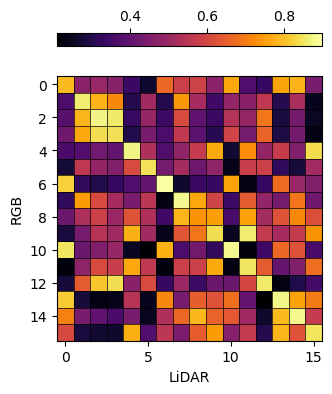

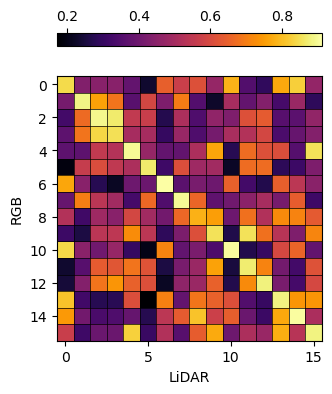

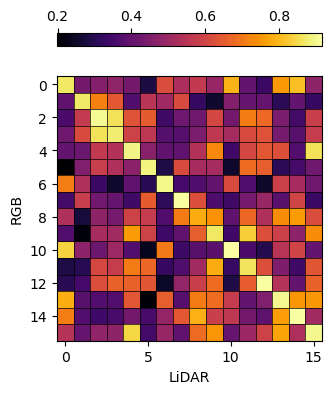

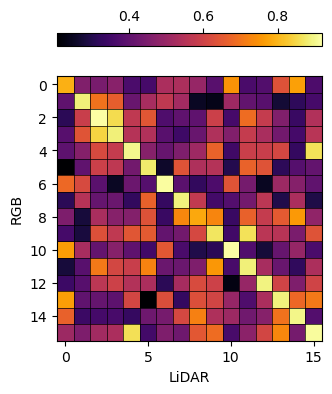

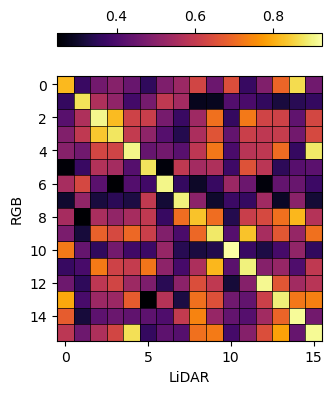

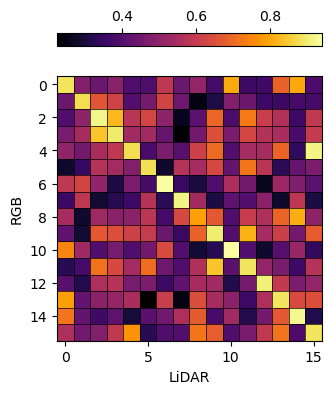

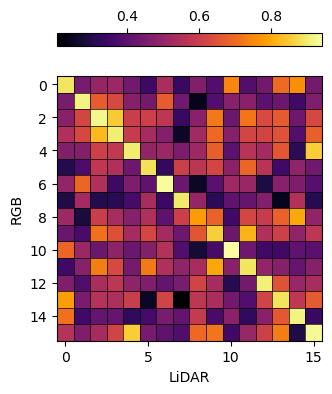

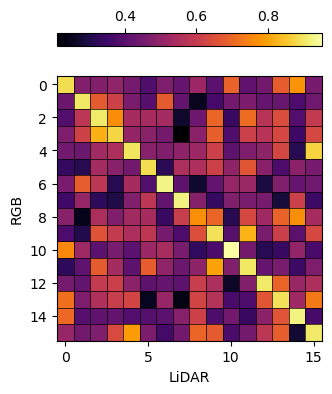

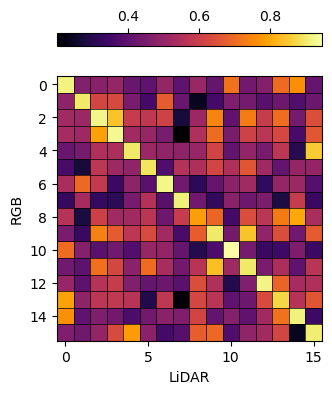

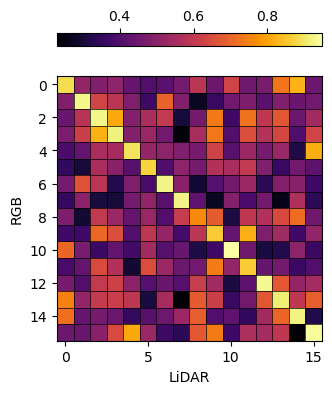

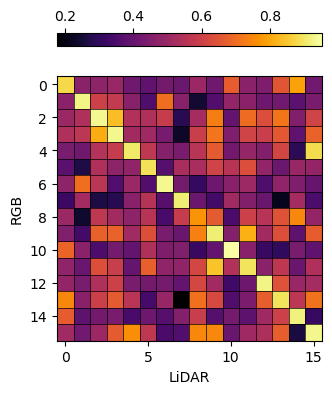

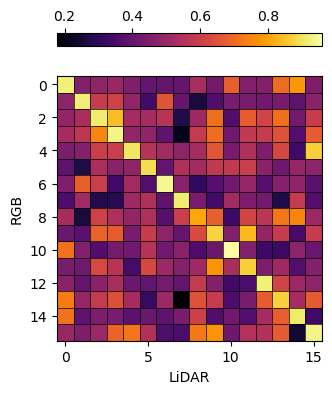

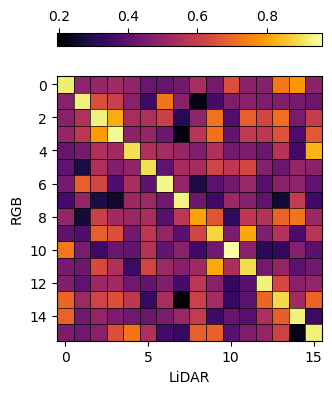

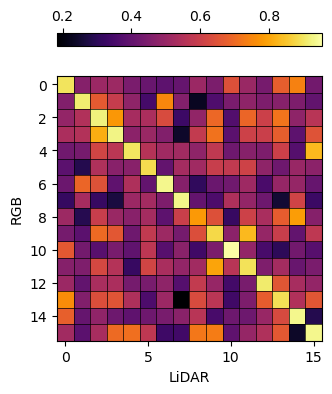

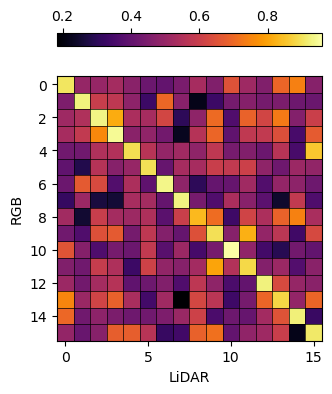

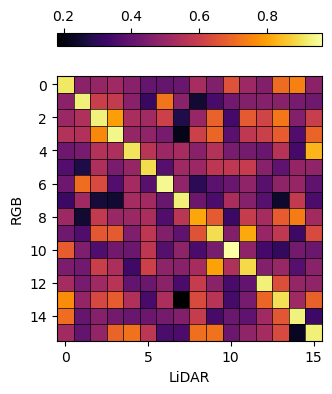

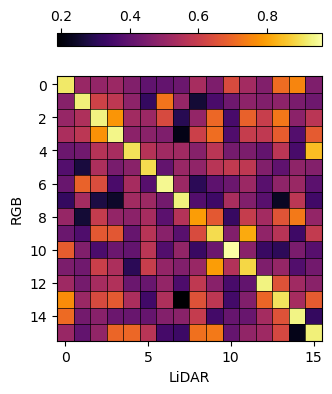

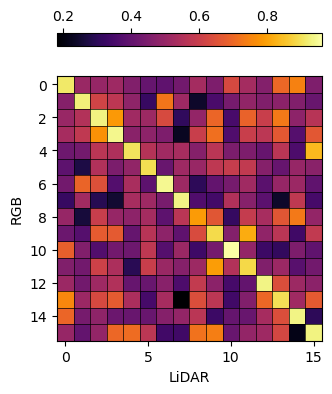

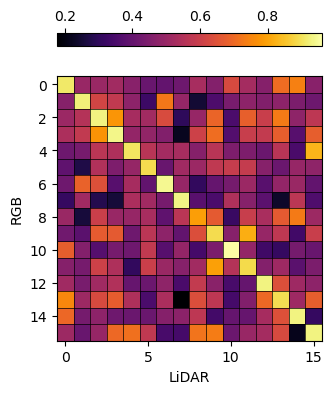

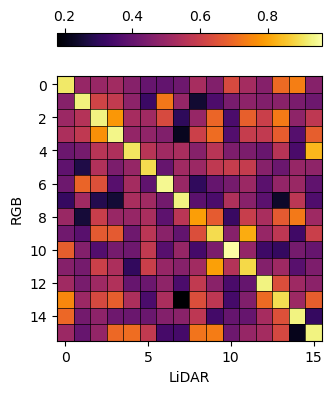

In [ ]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 20
LEARNING_RATE = 1e-4 

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1b_CILP_Contrastive",
    config={
        "architecture": "CILPModel",
        "fusion_strategy": "contrastive",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "subset_size": SUBSET_SIZE #train_N + valid_N #SUBSET_SIZE
    }
)

cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel

optimizer = torch.optim.Adam(cilp_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_cilp = train_fusion_cilp_model(
    cilp_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(), # CrossEntropy used for CILP too
    device="cuda", 
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="contrastive"
)

# TASK 5.1b CHECK REQUIREMENT:
check_value = 0.8 #3.2 #0.8
if metrics_cilp['val_loss'] < check_value:
    print(f"✅ Success! CILP Val Loss {metrics_cilp['val_loss']:.4f} is below {check_value}")

wandb.finish()

### Cross-Modal Projector (Step 5.2)

**Note on Cross-Modal Projector Validation Loss.**  In our setup, the projector maps RGB embeddings to LiDAR embeddings (`12800`-dim vectors). Due to the normalization of embeddings in the pretrained CILP model, the expected MSE for a randomly initialized projector is naturally **much lower than the 2.5 threshold** given in the assignment. Based on our observations, a practical and meaningful target for validation loss is `< 0.20`, which reflects effective learning progress of the projector aligning RGB embeddings to the LiDAR space.


In [5]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to("cuda")
new_cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.


In [6]:
def estimate_random_mse(embedding_dim=12800, batch_size=32, device="cpu"):
    """Estimate MSE for untrained projector assuming random embeddings and L2-normalized target embeddings."""
    # Random unit vectors for target and projector output
    target = torch.randn(batch_size, embedding_dim, device=device)
    # target = target / target.norm(dim=1, keepdim=True)
    pred = torch.randn(batch_size, embedding_dim, device=device) 
    pred = pred / pred.norm(dim=1, keepdim=True)    
    mse = torch.mean((pred - target)**2).item()
    return mse

embedding_dim = 3200
batch_size = 32
random_mse = estimate_random_mse(embedding_dim, batch_size, device="cuda" if torch.cuda.is_available() else "cpu")
print(f"Estimated random MSE (per batch): {random_mse:.5f}")

Estimated random MSE (per batch): 0.99515


In [ ]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 40
LEARNING_RATE = 1e-3

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.2_Projector_MSE",
    config={
        "architecture": "CrossModalProjector",
        "fusion_strategy": "projector",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS
    }
)

# Lidar intermediate flat dimension: 200 * 8 * 8 = 12800 or 200 * 4 * 4 = 3200
projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 4 * 4).to("cuda")

# We pass the frozen models to the loop via cilp_extras
extras = {
    'img_enc': cilp_model.img_embedder, 
    'lidar_cnn': lidar_model 
}

optimizer = torch.optim.Adam(projector.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_proj = train_fusion_cilp_model(
    projector, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.MSELoss(), # Projector criterion: MSE
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="projector", 
    scheduler=scheduler,
    cilp_extras=extras
)

# TASK 5.2 CHECK REQUIREMENT:
check_value = .6 - (.4*.6) #6e-6 - (.4*6e-6) #3e-5 - (.4*3e-5) # Set a target of reducing the initial validation MSE by 55%.
if metrics_proj['val_loss'] < check_value:
    print(f"✅ Success! Projector MSE {metrics_proj['val_loss']:.6f} is below {check_value}")

wandb.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 0: Val Loss: 0.080383, Acc: 0.00% | Mem: 225.4MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 1: Val Loss: 0.067681, Acc: 0.00% | Mem: 225.4MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 2: Val Loss: 0.061688, Acc: 0.00% | Mem: 225.4MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 3: Val Loss: 0.054712, Acc: 0.00% | Mem: 225.4MB
Accuracy not applicable to the cross-modal projector task
Epoc

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_time_sec,█▆▆▆▅▅▃▁▄▅▆▃▂▅▆▆▆▆▂▂▁▂▂▁▁▁▁▁▂▁▁▄▆▅▆▆▁▁▁▂
learning_rate,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
peak_gpu_mem_mb,▁▅▅▅▅███████████████████████████████████
train_loss,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0
epoch,39
epoch_time_sec,5.18181
learning_rate,0.0


### Step 5.3 Final Classifier Fine-Tuning 

In [8]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM, num_classes=1).to("cuda")
new_cilp_model = EfficientCILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda") #CILPModel
new_projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 4 * 4).to("cuda")

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")
projector = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_projector, task_mode="projector")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded projector model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
        Using instantiated model in `.train()` mode.


Before fine-tuning the final model, we evaluate its performance to verify that training has been meaningful. Specifically, when comparing the trained model against lidar-only inputs, a random baseline would yield approximately `50%` accuracy. Using the CILP model embedder together with the trained projector, we observe an accuracy of at least `70%`, indicating that the model effectively leverages the lidar signal rather than relying on chance.

In [9]:
final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to(DEVICE)
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

def get_correct(output, y):
    predicted = (torch.sigmoid(output) > 0.5).float()
    # _, predicted = torch.max(output.data, 1)
    return (predicted == y).sum().item()

def get_valid_metrics():
    final_cilp_classifier.eval()
    correct = 0
    batch_correct = 0
    for step, batch in enumerate(val_loader):
        rbg_img, _, class_idx = batch
        rbg_img, class_idx = rbg_img.to(DEVICE), class_idx.to(DEVICE)
        class_idx = class_idx.float().unsqueeze(1) 
        output = final_cilp_classifier(rbg_img)
        loss = criterion(output, class_idx)
        batch_correct = get_correct(output, class_idx)
        correct += batch_correct
    print(f"Valid Loss: {loss.item():2.4f} | Accuracy {correct/len(val_ds):2.4f}") #len(val_ds) valid_N

get_valid_metrics()

Valid Loss: 0.1537 | Accuracy 0.9292


In [11]:
epochs = 20

final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to(DEVICE)
final_cilp_classifier.train()
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()


for param in final_cilp_classifier.rgb_enc.features.parameters():
    param.requires_grad = False
# for param in final_cilp_classifier.rgb_enc.features[-3:].parameters():
#     param.requires_grad = True
for param in final_cilp_classifier.rgb_enc.fc_emb.parameters():
    param.requires_grad = True
for param in final_cilp_classifier.projector.parameters():
    param.requires_grad = True
for param in final_cilp_classifier.lidar_classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
    # {'params': final_cilp_classifier.rgb_enc.features[-3:].parameters(), 'lr': 1e-6}, # Tiny adjustment
    {'params': final_cilp_classifier.rgb_enc.fc_emb.parameters(), 'lr': 1e-5}, 
    {'params': final_cilp_classifier.projector.parameters(), 'lr': 3e-5},
    {'params': final_cilp_classifier.lidar_classifier.parameters(), 'lr': 1e-5} # Boosted from 1e-6
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs+5)

best_val_acc = 0.0
for epoch in range(epochs):
    correct = 0
    batch_correct = 0
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        rbg_img, _, class_idx = batch
        rbg_img, class_idx = rbg_img.to(DEVICE), class_idx.to(DEVICE)
        output = final_cilp_classifier(rbg_img)
        class_idx = class_idx.float().unsqueeze(1) 
        loss = criterion(output, class_idx)
        batch_correct = get_correct(output, class_idx)
        correct += batch_correct
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_cilp_classifier.parameters(), max_norm=1.0)
        optimizer.step()
    scheduler.step()
    
    final_cilp_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for r_img, _, c_idx in val_loader:
            r_img, c_idx = r_img.to(DEVICE), c_idx.to(DEVICE).float().unsqueeze(1)
            out = final_cilp_classifier(r_img)
            loss = criterion(out, c_idx)
            preds = (torch.sigmoid(out) > 0.5).float()
            correct += (preds == c_idx).sum().item()
            total += c_idx.size(0)
    
    val_acc = correct / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
    
    print(f"Epoch {epoch} | Val Loss: {loss.item():2.4f} | Val Acc: {val_acc*100:.2f}% | Best: {best_val_acc*100:.2f}%")
    
    # if best_val_acc >= 0.95:
    #     print("Target reached")
    #     break
    # print(f"Train Loss: {loss.item():2.4f} | Accuracy {correct/len(train_ds):2.4f}") #len(train_ds) train_N
    get_valid_metrics()

Epoch 0 | Val Loss: 0.0081 | Val Acc: 95.19% | Best: 95.19%
Valid Loss: 0.0081 | Accuracy 0.9392
Epoch 1 | Val Loss: 0.0054 | Val Acc: 95.95% | Best: 95.95%
Valid Loss: 0.0054 | Accuracy 0.9467
Epoch 2 | Val Loss: 0.1092 | Val Acc: 95.02% | Best: 95.95%
Valid Loss: 0.1092 | Accuracy 0.9375
Epoch 3 | Val Loss: 0.1801 | Val Acc: 95.44% | Best: 95.95%
Valid Loss: 0.1801 | Accuracy 0.9417
Epoch 4 | Val Loss: 0.0303 | Val Acc: 95.69% | Best: 95.95%
Valid Loss: 0.0303 | Accuracy 0.9442
Epoch 5 | Val Loss: 0.0370 | Val Acc: 95.78% | Best: 95.95%
Valid Loss: 0.0370 | Accuracy 0.9450
Epoch 6 | Val Loss: 0.0134 | Val Acc: 95.69% | Best: 95.95%
Valid Loss: 0.0134 | Accuracy 0.9442
Epoch 7 | Val Loss: 0.0684 | Val Acc: 95.52% | Best: 95.95%
Valid Loss: 0.0684 | Accuracy 0.9425
Epoch 8 | Val Loss: 0.1124 | Val Acc: 95.86% | Best: 95.95%
Valid Loss: 0.1124 | Accuracy 0.9458
Epoch 9 | Val Loss: 0.1149 | Val Acc: 95.19% | Best: 95.95%
Valid Loss: 0.1149 | Accuracy 0.9392
Epoch 10 | Val Loss: 0.0293 | 

In [ ]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 20
LEARNING_RATE = 1e-3 #5e-4

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.3_Fine-tuning_Lidar_Only",
    config={
        "architecture": "RGB2LiDARClassifier",
        "fusion_strategy": "fine-tuning",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS
    }
)

# Lidar intermediate flat dimension: 200 * 8 * 8 = 12800
# final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to("cuda")

optimizer = torch.optim.Adam(final_cilp_classifier.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_proj = train_fusion_cilp_model(
    final_cilp_classifier, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(), # Classifier criterion: CE
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="fine-tuning", 
    # scheduler=scheduler,
)

# TASK 5.3 CHECK REQUIREMENT:
check_value = 0.95
if metrics_proj['accuracy']/100 > check_value:
    print(f"✅ Success! Validation accuracy is {metrics_proj['accuracy']:.2f}% after fine-tuning, above {check_value}")

wandb.finish()

Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 0: Val Loss: 0.4276, Acc: 81.59% | Mem: 156.2MB
Epoch 1: Val Loss: 0.4403, Acc: 80.15% | Mem: 156.2MB
Epoch 2: Val Loss: 0.4288, Acc: 79.81% | Mem: 156.2MB
Epoch 3: Val Loss: 0.5254, Acc: 74.32% | Mem: 156.2MB
Epoch 4: Val Loss: 0.4474, Acc: 79.81% | Mem: 156.2MB
Epoch 5: Val Loss: 0.4824, Acc: 76.01% | Mem: 156.2MB
Epoch 6: Val Loss: 0.4288, Acc: 80.24% | Mem: 156.2MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 7: Val Loss: 0.4264, Acc: 79.65% | Mem: 156.2MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 8: Val Loss: 0.4147, Acc: 80.07% | Mem: 156.2MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/

accuracy,▆▅▅▁▅▂▅▅▅▆█▄▃▆▆▇█▆▇▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,▂▂▁▁▁▁▂▁▂▂▂▇█▇▇██▇▅▅
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
peak_gpu_mem_mb,▁▅██████████████████
train_loss,█▄▃▄▃▃▂▂▃▂▂▂▁▂▂▂▂▂▁▁
val_loss,▄▅▄█▅▆▄▄▃▃▂▄▇▃▃▂▁▃▂▆
accuracy,76.94257
epoch,19
epoch_time_sec,5.31946
learning_rate,0.001


In [17]:
final_cilp_classifier.eval()

correct = 0
total = 0
batch_count = 0

print("Testing final classifier on 5 validation batches...")

correct, total = 0, 0
with torch.no_grad():
    for r_img, _, c_idx in val_loader:
        r_img, c_idx = r_img.to(DEVICE), c_idx.to(DEVICE).float().unsqueeze(1)
        out = final_cilp_classifier(r_img)
        loss = criterion(out, c_idx)
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == c_idx).sum().item()
        total += c_idx.size(0)

final_acc = 100 * correct / total
print(f"\nFinal Results (Transfer Learning RGB -> Projector -> LiDAR Head):")
print(f"Accuracy: {final_acc:.2f}%")

if final_acc > 95.0:
    print("✅ Success! Accuracy is above 95%")
else:
    print("❌ Accuracy below 95%. Consider training CILP or Projector for more epochs.")

Testing final classifier on 5 validation batches...

Final Results (Transfer Learning RGB -> Projector -> LiDAR Head):
Accuracy: 95.69%
✅ Success! Accuracy is above 95%
